## Semantic Chunking 
Isn't it weird that we have a global constant for chunk size? Isn't it even weirder that our normal chunking mechanisms don't take into account the actual content?

I'm not the only one who thinks so

<div style="text-align: center;">
    <img src="images/SemanticChunkingTweet.png" style="max-width:50%; height:auto;"><br>
    <span><i><a href="https://twitter.com/thesephist/status/1724159343237456248?s=46">Source</a></i></span>
</div>

There has to be a better way - let's explore and find out.

Embeddings represent the semantic meaning of a string. They don't do much on their own, but when compared to embeddings of other texts you can start to infer the relationship between chunks. I want to lean into this property and explore using embeddings to find clusters of semantically similar texts.

The hypothesis is that semantically similar chunks should be held together.

I tried a few methods:
1) **Heirarchical clustering with positional reward** - I wanted to see how heirarchical clustering of sentence embeddings would do. But because I chose to split on sentences, there was an issue with small short sentences after a long one. You know? (like this last sentenence). They could change the meaning of a chunk, so I added a positional reward and clusters were more likely to form if they were sentences next to each other. This ended up being ok, but tuning the parameters was slow and unoptimal.
2) **Find break points between sequential sentences** - Next up I tried a walk method. I started at the first sentence, got the embedding, then compared it to sentence #2, then compared #2 and #3 and so on. I was looking for "break points" where embedding distance was large. If it was above a threshold, then I considered it the start of a new semantic section. I originally tried taking embeddings of every sentence, but this turned out to be too noisy. So I ended up taking groups of 3 sentences (a window), then got an embedding, then dropped the first sentence, and added the next one. This worked out a bit better.

I'll show method #2 here - It's not perfect by any means, but it's a good starting point for an exploration and I'd love to hear about how you think it could be improved.

First, let's load up our essay that we'll run through. I'm just doing a single essay here to keep the tokens down.

We'll be using Paul Graham's [MIT essay](https://paulgraham.com/mit.html)

In [ ]:
%pip install openai python-dotenv --quiet

In [7]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [1]:
with open('../data/mit.txt') as file:
    essay = file.read()

Then I want to split the entire essay into 1-sentence chunks. I'm going to split on "." "?" and "!". There are better ways to do this but this is quick and easy for now.

In [2]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} senteneces were found")

317 senteneces were found


But a list of sentences can be tough to add more data too. I'm going to turn this into a list of dictionaries (`List[dict]`), of which, the sentences will be a key-value. Then we can start to add more data to each sentence.

In [3]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': '\n\nWant to start a startup?', 'index': 0},
 {'sentence': 'Get funded by\nY Combinator.', 'index': 1},
 {'sentence': 'October 2006(This essay is derived from a talk at MIT.)\nTill recently graduating seniors had two choices: get a job or go\nto grad school.',
  'index': 2}]

Great, now that we have our sentences, I want to combine the sentence before and after so that we reduce noise and capture more of the relationships between sequential sentences.

Let's create a function so we can use it again. The `buffer_size` is configurable so you can select how big of a window you want. Keep this number in mind for the later steps. I'll just use `buffer_size=1` for now.

In [4]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [5]:
sentences[:3]

[{'sentence': '\n\nWant to start a startup?',
  'index': 0,
  'combined_sentence': '\n\nWant to start a startup? Get funded by\nY Combinator.'},
 {'sentence': 'Get funded by\nY Combinator.',
  'index': 1,
  'combined_sentence': '\n\nWant to start a startup? Get funded by\nY Combinator. October 2006(This essay is derived from a talk at MIT.)\nTill recently graduating seniors had two choices: get a job or go\nto grad school.'},
 {'sentence': 'October 2006(This essay is derived from a talk at MIT.)\nTill recently graduating seniors had two choices: get a job or go\nto grad school.',
  'index': 2,
  'combined_sentence': 'Get funded by\nY Combinator. October 2006(This essay is derived from a talk at MIT.)\nTill recently graduating seniors had two choices: get a job or go\nto grad school. I think there will increasingly be a third option:\nto start your own startup.'}]

Check out how the 2nd sentence (index #1) has the first sentence and 3rd sentence in its `combined_sentence` key now.

Now I want to get embeddings for the combined sentences, so we can get the distances between the groups of 3 and find breakpoints. I'll use OpenAI's embeddings for this.

In [8]:
from langchain_openai import AzureOpenAIEmbeddings

oaiembeds = AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv("AZURE_OPENAI_EMBEDDING_ENDPOINT"),
    openai_api_key=os.getenv("AZURE_OPENAI_EMBEDDING_API_KEY"),
    openai_api_version=os.getenv("AZURE_OPENAI_EMBEDDING_API_VERSION"),
    azure_deployment="text-embedding-3-small",
)



Now let's go get our embeddings. We'll do this in batch to make it quicker.

In [9]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

Now we have a list of embeddings, but we need to add them to our list of dicts

In [10]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

Great, now we're getting to the cool part, let's check out the cosine distances between sequential embedding pairs to see where the break points are. We'll add 'distance_to_next' as another key

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

Great, now let's pull out the distances from our sentences and then add them as well

In [12]:
distances, sentences = calculate_cosine_distances(sentences)

Let's take a look at what our distances array looks like.

In [13]:
distances[:3]

[0.24503556486607658, 0.06516025341970244, 0.15746156451372495]

Hm, yep, just a bunch of numbers that aren't fun to look at. Let's plot them.

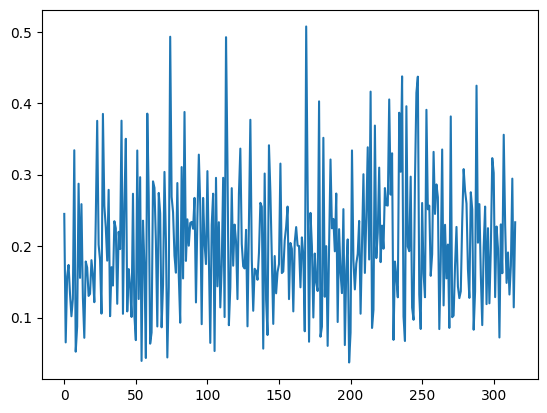

In [14]:
import matplotlib.pyplot as plt
plt.plot(distances);

Hm, cool! It's interesting to see sections where distances are smaller and then areas of larger distances. What stands out to me most is the outliers which are spread out.

There are many ways to chunk up the essay based off these distances, but I'm going to consider any distance above the 95th percentile of distances as a break point. This is the only parameter we'll need to config.

I'm going to build in the final viz, check out the video for an iterative build and an overview.

Let's look at the chunks that came out

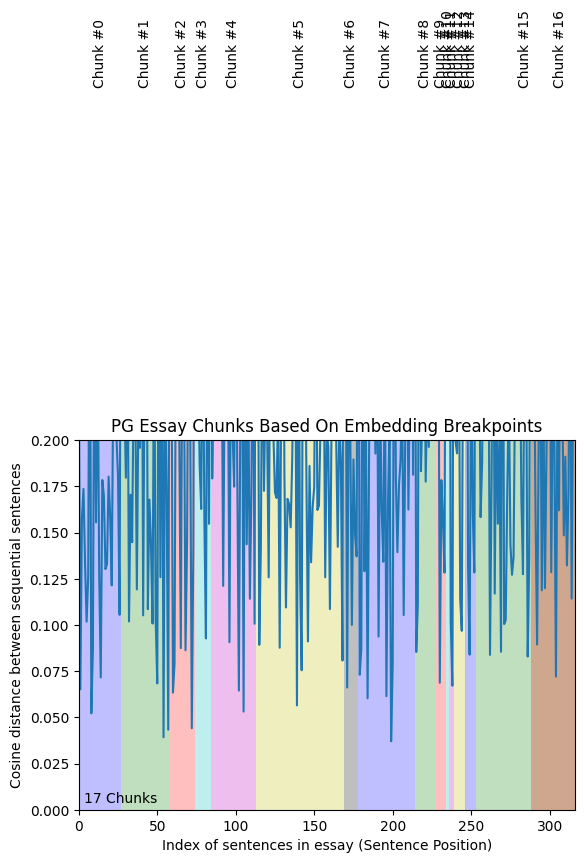

In [19]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

Well now that we've succefully distracted ourselves with a visualization, now we need to combine the sentences into chunks.

Because we have our breakpoints [23, 40, 51...] I want to make the first chunk 0-22, since the distance jumped on sentence 23.

In [16]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

Great now let's manually inspect a few to make sure they look ok.

In [17]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
Want to start a startup? Get funded by
Y Combinator. October 2006(This essay is derived from a talk at MIT.)
Till recently graduating seniors had two choices: get a job or go
to grad school. I think
...
if you start a startup explicitly to get rich, the money you
might get seems pretty theoretical most of the time. What drives
you day to day is not wanting to look bad.You probably can't change that.


Chunk #1
Even if you could, I don't think
you'd want to; someone who really, truly doesn't care what his peers
think of him is probably a psychopath. So the best you can do is
consider this force like a wind,
...
hs are: stamina, poverty, rootlessness,
colleagues, and ignorance.The importance of stamina shouldn't be surprising. If you've heard
anything about startups you've probably heard about the long hours.




I want to re-emphasize that this is an exploration of a method that is far from usable yet. This method should be tested with RAG eval to ensure that it works for your use case.

I didn't worry about chunk size or overlap with this method, but you could recursively split large chunks if you needed to.

How should it be improved? Let me [know](https://twitter.com/GregKamradt)! See me tease this [here](https://twitter.com/GregKamradt/status/1737921395974430953).